HARD

**Построение лестницы Ламерея**

Лестница Ламерея (диаграмма Лемерея, cobweb plot) - это один из графических способов исследовать траектории отображений вида $x_{n+1} = g(x_n)$, в том числе логистического отображения, где по одной оси откладывается $x_n$, а по другой $x_{n+1}$. На таком графике одновременно изображаются кривая $y = g(x)$ и биссектриса $y=x$, а сама «лестница» получается, если из точки $(x_n, x_n)$ провести вертикаль до кривой, затем горизонталь до биссектрисы, что соответствует одному шагу итерации $x_n -> x_{n+1}$

В коде функция cobweb автоматизирует эту процедуру: сначала строится график $g(x,r)$ и прямая $y=x$, затем в цикле по числу итераций рисуются вертикальные и горизонтальные отрезки, которые характерисуют к чему стремится предел при фиксированном параметре $r$ и начальном значении  $x_0$
Выбор нескольких разных значений $r$ позволяет сравнить устойчивую неподвижную точку, циклы порядка $2, 4$ и более, а также переход к хаосу, где лестница «заполняет» некоторую область

**Циклы и их визуализация**

На лестнице Ламерея неподвижная точка появляется там, где отрезки лестницы всё ближе подходят к точке пересечения кривой $y=g(x)$ с биссектрисой $y=x$. при устойчивой фиксированной точке длина ступенек убывает и траектория останавливается в этой точке. второй цикл представлен «прямоугольником»: точка прыгает между двумя точками, и лестница замыкается, образуя фигуру из четырёх отрезков, а для циклов более высоких порядков возникают более сложные замкнутые многоугольники

Если же отображение переходит в хаос, конечный цикл отсутствует, и на диаграмме Лемерея видно множество неповторяющихся шагов, заполняющих область между кривой $y=g(x)$ и диагональю. Для логистического отображения $x_n+1 = r x_n(1 - x_n)$ такое появляктся при малых $r$ наблюдается сходимость к одной точке, потом появляются циклы длины $2$, $4$, $8$ и так далее, а затем - хаос с периодичными периодами

**Изменение длины цикла при изменении r**

Вторая часть кода смотрит то, как меняется длина цикла при изменении параметра $r$: для каждого значения $r$ сначала проходит достаточно длинный начальный отрезок начала, чтобы устаканиться, затем по оставшейся последовательности численно оценивается период (до некоторого максимального, например 64), и результатои будут точки на плоскости $(r,period)$. При конечных периодах видны горизонтальные уровни (1, 2, 4, 8...), а в диапазонах, где период не удаётся обнаружить в заданных пределах, точки условно помещаются на уровень хаос / слишком длинный цикл.

Для логистического отображения известно, что при увеличении $r$ от примерно 3 до около 3.57 наблюдается удвоение периода: сначала устойчивый фиксированный пункт, затем цикл длины 2, затем 4, 8 и так далее, после чего система переходит в хаотический режим с многочисленными периодическими циклами. Если в функцию $g$ подставить другой нелинейный закон с одним максимумом, то график «длина цикла r» обычно демонстрирует очень похожую структуру: участки устойчивых циклов,удвоение периода и хаос, это позволяет говорить о близости поведения такого отображения к логистическому

1. Определяем отображение *g(x, r)* (здесь по умолчанию - логистическое отображение)
2. лестница Лампера *cobweb*
3. функции для поиска периода *compute*, *detect_period*, *scan_periods*

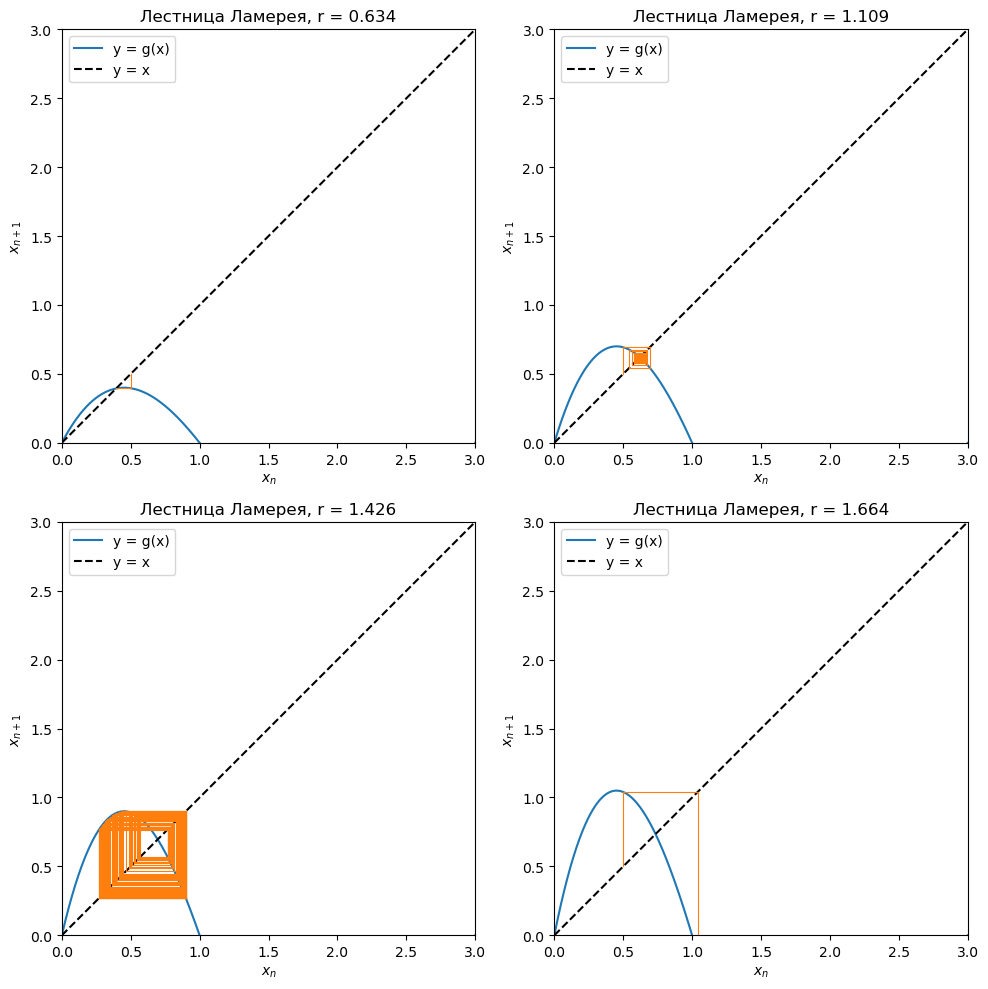

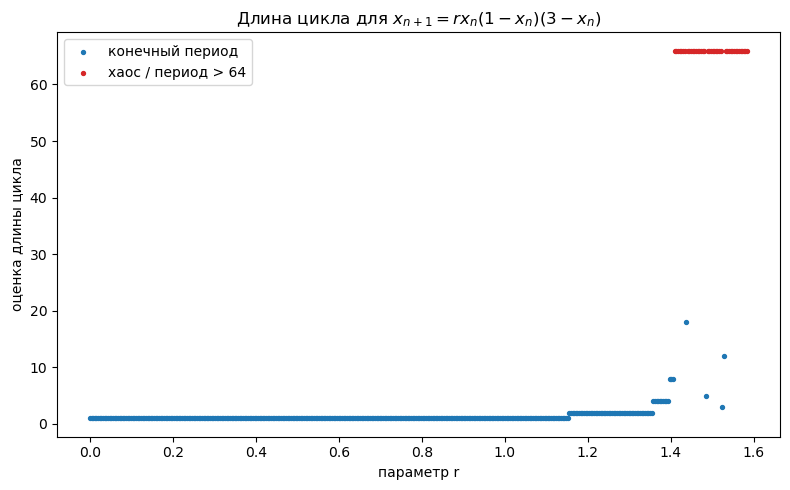

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def g(x, r):
    return r * x * (1.0 - x) * (3.0 - x)

R_MAX = 27.0 / (2.0 * (7.0 * np.sqrt(7.0) - 10.0))
R_MIN = 0.0

def cobweb(g, r, x0=0.5, n_iter=80,
           x_min=0.0, x_max=3.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    xs = np.linspace(x_min, x_max, 800)
    ax.plot(xs, g(xs, r), 'C0', label='y = g(x)')
    ax.plot(xs, xs, 'k--', label='y = x')

    x = x0
    for _ in range(n_iter):
        y = g(x, r)
        ax.plot([x, x], [x, y], 'C1', lw=0.8)
        ax.plot([x, y], [y, y], 'C1', lw=0.8)
        x = y
    ax.set_xlabel(r'$x_n$')
    ax.set_ylabel(r'$x_{n+1}$')
    ax.set_title(f'Лестница Ламерея, r = {r:.3f}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(x_min, x_max)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    return ax

def compute(g, r, x0=0.5, n_transient=1500, n_iter=512):
    x = x0
    for _ in range(n_transient):
        x = g(x, r)
    startline = np.empty(n_iter)
    for i in range(n_iter):
        x = g(x, r)
        startline[i] = x
    return startline


def detect_period(startline, tol=1e-6, max_period=64):
    N = len(startline)
    for p in range(1, max_period + 1):
        if np.all(np.abs(startline[p:] - startline[:-p]) < tol):
            return p
    return np.inf


def scan_periods(g, r_values, x0=0.5,
                 n_transient=1500, n_iter=512,
                 tol=1e-6, max_period=64):
    periods = []
    for r in r_values:
        startline = compute(g, r, x0=x0,
                            n_transient=n_transient,
                            n_iter=n_iter)
        periods.append(detect_period(startline, tol=tol,
                                     max_period=max_period))
    return np.array(periods)

if __name__ == "__main__":
    r_values_demo = [
        0.4 * R_MAX,
        0.7 * R_MAX,
        0.9 * R_MAX,
        1.05 * R_MAX
    ]
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for r, ax in zip(r_values_demo, axes.ravel()):
        cobweb(g, r, x0=0.5, n_iter=120, ax=ax)
    fig.tight_layout()
    plt.show()
    r_values = np.linspace(R_MIN, R_MAX, 400)
    periods = scan_periods(g, r_values,
                           x0=0.5,
                           n_transient=2000,
                           n_iter=512,
                           tol=1e-6,
                           max_period=64)
    max_period = 64
    fig, ax = plt.subplots(figsize=(8, 5))
    mask_finite = np.isfinite(periods)
    ax.scatter(r_values[mask_finite], periods[mask_finite],
               s=8, color='C0', label='конечный период')
    mask_inf = ~mask_finite
    if np.any(mask_inf):
        ax.scatter(r_values[mask_inf],
                   np.full(np.sum(mask_inf), max_period + 2),
                   s=8, color='C3',
                   label='хаос / период > 64')
    ax.set_xlabel('параметр r')
    ax.set_ylabel('оценка длины цикла')
    ax.set_title('Длина цикла для $x_{n+1}=r x_n(1-x_n)(3-x_n)$')
    ax.legend()
    plt.tight_layout()
    plt.show()

